In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# ===============================
# 1) Load and prepare the image
# ===============================

print("[INFO] Loading the image...")

image_path = "/Users/jmlaurie/Downloads/Map2.png"
image = cv2.imread(image_path)
if image is None:
    raise IOError(f"Could not read image at {image_path}")

# Convert to RGB for easier thresholding
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Identify which pixels are playable vs. not playable
# (In this example, anything that is not near-white is "playable".)
white_lower = np.array([245, 245, 245])
white_upper = np.array([255, 255, 255])
white_mask = cv2.inRange(image_rgb, white_lower, white_upper)

# mask > 0 => playable area
# The user’s code had: playable_mask = np.bitwise_not(white_mask)
# But let’s keep it as a binary (0/1) image for distance transform.
playable_mask = cv2.bitwise_not(white_mask)  # 255 where playable, 0 where not

# Convert from 255 to 1
playable_mask_01 = (playable_mask > 0).astype(np.uint8)

# For quick referencing of shape
height, width = playable_mask_01.shape

 

[INFO] Loading the image...


In [2]:
# =========================
# 2) Distance from wall
# =========================
print("[INFO] Computing distance from each playable pixel to the nearest wall...")
# OpenCV distanceTransform requires:
#   - src: 8-bit, single-channel binary image (non-zero=foreground)
#   - distanceType: e.g., cv2.DIST_L2
#   - maskSize: e.g., 3 or 5
dist_transform = cv2.distanceTransform(playable_mask_01, cv2.DIST_L2, 3)

# dist_transform[y, x] is the (Euclidean) distance to the nearest 0 pixel,
# i.e., to the nearest non-playable “wall.”

[INFO] Computing distance from each playable pixel to the nearest wall...


In [3]:
# ================================================
# 3) Coverage function (line-of-sight, naive)
# ================================================
def is_valid(x, y, mask):
    """
    Check if (x, y) is within bounds and in the playable area.
    Note: x = col, y = row in image indexing.
    """
    h, w = mask.shape
    row, col = int(round(y)), int(round(x))
    if 0 <= row < h and 0 <= col < w:
        return (mask[row, col] > 0)
    return False

def compute_coverage(x, y, mask, num_rays=36, max_steps=200):
    """
    Cast rays in multiple directions from (x, y).
    Returns the number of unique points reached within the playable area.
    
    - num_rays: number of angles (0..360) in increments of 360/num_rays
    - max_steps: how many steps to travel along each ray before giving up
    """
    visited = set()
    
    if not is_valid(x, y, mask):
        return 0
    
    step_size = 1.0  # you can tweak step_size to be > 1 for speed
    
    for ray_i in range(num_rays):
        angle_deg = 360.0 * ray_i / num_rays
        angle_rad = math.radians(angle_deg)
        
        for step in range(max_steps):
            xx = x + step * step_size * math.cos(angle_rad)
            yy = y + step * step_size * math.sin(angle_rad)
            
            # stop if out of bounds or not playable
            if not is_valid(xx, yy, mask):
                break
            
            # collect visited as integer pixel coordinates
            visited.add((int(round(xx)), int(round(yy))))
    
    return len(visited)



In [4]:

# ======================================================
# 4) Build a table (DataFrame) for all playable pixels
# ======================================================

print("[INFO] Looping over all pixels to compute coverage and distance. This can be slow...")

rows = []  # will hold [x, y, coverage, distance]

# If your map is large, consider skipping some pixels for speed, e.g. range(0, width, 5)
# or implementing a more optimized approach. Here, we do them all.
for y in range(height):
    for x in range(width):
        # Check if playable
        if playable_mask_01[y, x] == 1:
            # coverage
            coverage_val = compute_coverage(x, y, playable_mask, num_rays=36, max_steps=200)
            # distance from wall
            distance_val = dist_transform[y, x]
            rows.append([x, y, coverage_val, distance_val])

print("[INFO] Building the DataFrame...")

df = pd.DataFrame(rows, columns=["X Value", "Y Value", "Coverage", "Distance from Wall"])
print("[INFO] Finished creating DataFrame!")

print("\nSample of the resulting table:")
print(df.head(10))

# You now have a DataFrame with the requested columns.


[INFO] Looping over all pixels to compute coverage and distance. This can be slow...
[INFO] Building the DataFrame...
[INFO] Finished creating DataFrame!

Sample of the resulting table:
   X Value  Y Value  Coverage  Distance from Wall
0      705      139       909            0.955002
1      706      139       921            0.955002
2      707      139       880            0.955002
3      708      139       889            0.955002
4      709      139       892            0.955002
5      710      139       903            0.955002
6      711      139       921            0.955002
7      712      139       929            0.955002
8      713      139       931            0.955002
9      714      139       947            0.955002


[INFO] Preparing heatmaps...


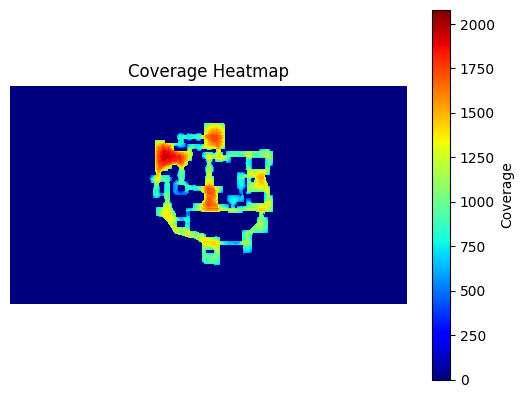

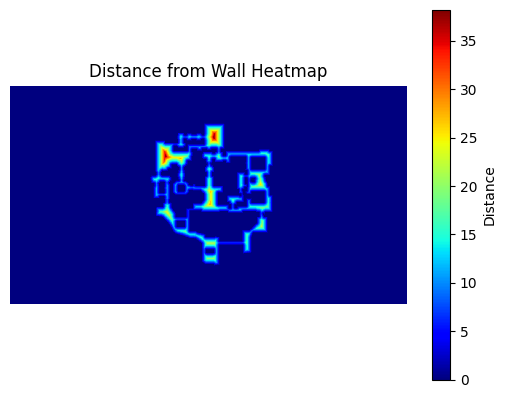

[INFO] All done! Data is in the 'df' DataFrame.


In [5]:

# ===========================
# 5) Plots and Illustrations
# ===========================

# Let's do two example plots:
#   1) A heatmap of coverage
#   2) A heatmap of distance from wall
# We'll construct 2D arrays for coverage and distance so we can do imshow.

print("[INFO] Preparing heatmaps...")

# Initialize empty arrays (float) for coverage and distance
coverage_map = np.zeros((height, width), dtype=np.float32)
distance_map = np.zeros((height, width), dtype=np.float32)

# Fill in known playable pixels
for row in rows:
    x_val, y_val, cov, distw = row
    coverage_map[y_val, x_val] = cov
    distance_map[y_val, x_val] = distw

# Coverage heatmap
plt.imshow(coverage_map, cmap='jet', interpolation='nearest')
plt.title("Coverage Heatmap")
plt.colorbar(label="Coverage")
plt.axis('off')
plt.show()

# Distance-from-wall heatmap
plt.imshow(distance_map, cmap='jet', interpolation='nearest')
plt.title("Distance from Wall Heatmap")
plt.colorbar(label="Distance")
plt.axis('off')
plt.show()

print("[INFO] All done! Data is in the 'df' DataFrame.")
